In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
import torch.nn as nn

class RBFLayerModified(nn.Module):
    def __init__(self, in_features_dim, num_kernels, out_features_dim,
                 radial_function, norm_function, normalization=True):
        super(RBFLayerModified, self).__init__()
        self.in_features_dim = in_features_dim
        self.num_kernels = num_kernels
        self.out_features_dim = out_features_dim
        self.radial_function = radial_function
        self.norm_function = norm_function
        self.normalization = normalization

        self.weights = nn.Parameter(torch.randn(out_features_dim, num_kernels))
        self.kernels_centers = nn.Parameter(torch.randn(num_kernels, in_features_dim))
        self.log_shapes = nn.Parameter(torch.randn(num_kernels))

    def forward(self, input):
        batch_size = input.size(0)
        c = self.kernels_centers.unsqueeze(0).expand(batch_size, *self.kernels_centers.size())
        diff = input.unsqueeze(1) - c
        r = self.norm_function(diff)
        eps_r = torch.exp(self.log_shapes).unsqueeze(0) * r
        rbfs = self.radial_function(eps_r)
        if self.normalization:
            rbfs = rbfs / (1e-9 + rbfs.sum(dim=-1, keepdim=True))
        out = torch.matmul(rbfs, self.weights.t())
        return out

def gaussian_rbf(x):
    return torch.exp(-x.pow(2))

def l2_norm(x):
    return torch.norm(x, p=2, dim=-1)


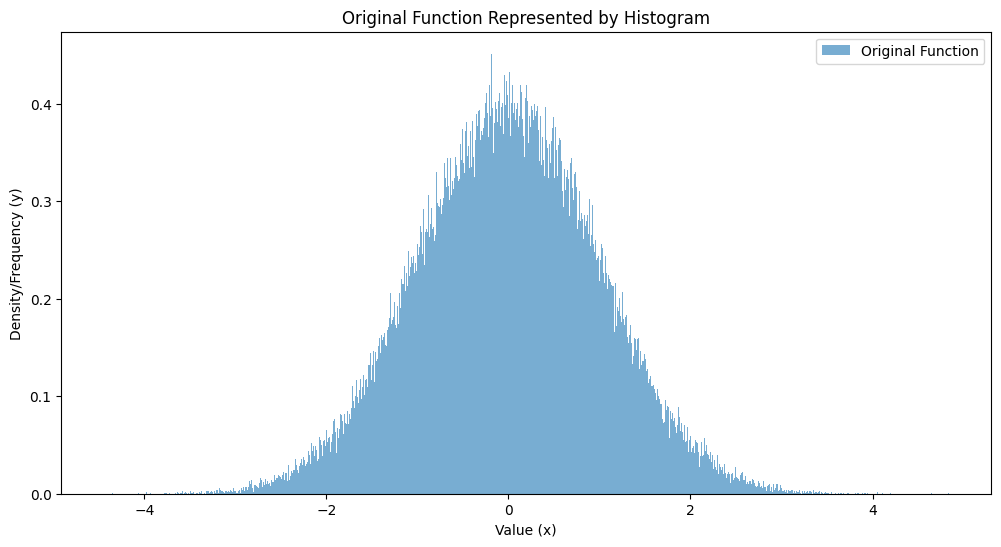

In [66]:
num_samples = 100000
data = torch.randn(num_samples)


num_bins = 1000
hist, bin_edges = np.histogram(data.numpy(), bins=num_bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])


x_train = torch.tensor(bin_centers, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(hist, dtype=torch.float32).unsqueeze(1)
z_train = torch.FloatTensor(num_bins).uniform_(0, 1).unsqueeze(1)

rbf_layer_for_hist = RBFLayerModified(
    in_features_dim=1,
    num_kernels=100,
    out_features_dim=1,
    radial_function=gaussian_rbf,
    norm_function=l2_norm
)

plt.figure(figsize=(12, 6))
plt.bar(x_train.squeeze(), y_train.squeeze(), width=(bin_edges[1]-bin_edges[0]), alpha=0.6, label='Original Function')


plt.title('Original Function Represented by Histogram')
plt.xlabel('Value (x)')
plt.ylabel('Density/Frequency (y)')
plt.legend()
plt.show()




In [67]:
import torch.optim as optim


optimizer = optim.Adam(rbf_layer_for_hist.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()


epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = rbf_layer_for_hist(x_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')


Epoch 0: Loss = 0.13631953299045563
Epoch 100: Loss = 0.00016438539023511112
Epoch 200: Loss = 0.00012865343887824565
Epoch 300: Loss = 0.0001241978316102177
Epoch 400: Loss = 0.00012099842570023611
Epoch 500: Loss = 0.00011857881327159703
Epoch 600: Loss = 0.0001170237228507176
Epoch 700: Loss = 0.0001160161045845598
Epoch 800: Loss = 0.00011530155461514369
Epoch 900: Loss = 0.00011474961502244696


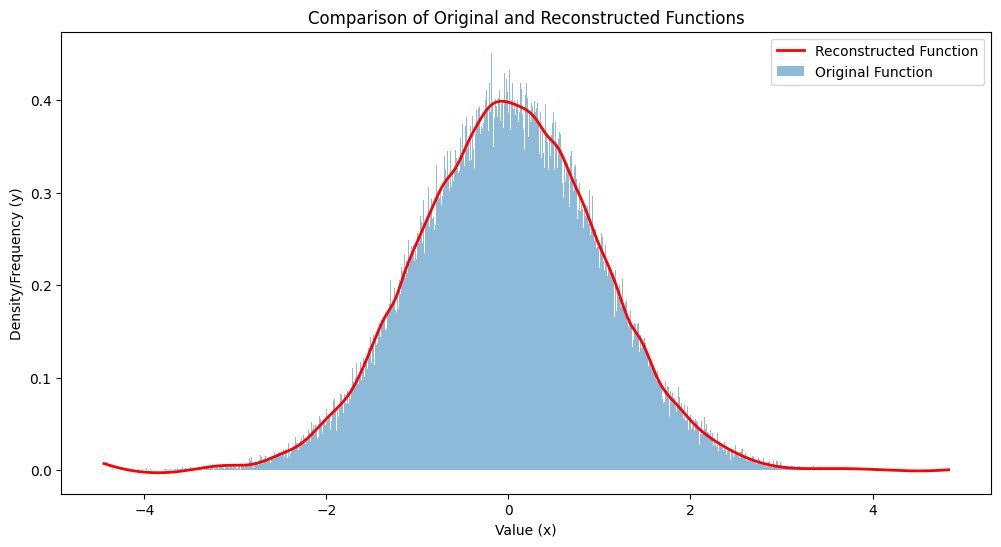

In [69]:
# Predict densities using the trained RBFLayer
y_pred_train = rbf_layer_for_hist(x_train).detach()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(x_train.squeeze(), y_train.squeeze(), width=(bin_edges[1]-bin_edges[0]), alpha=0.5, label='Original Function')
plt.plot(x_train.squeeze(), y_pred_train.squeeze(), label='Reconstructed Function', color='red', linewidth=2)
plt.title('Comparison of Original and Reconstructed Functions')
plt.xlabel('Value (x)')
plt.ylabel('Density/Frequency (y)')
plt.legend()
plt.show()


In [57]:
learned_weights = rbf_layer_for_hist.weights
learned_centers = rbf_layer_for_hist.kernels_centers
learned_shapes = rbf_layer_for_hist.log_shapes

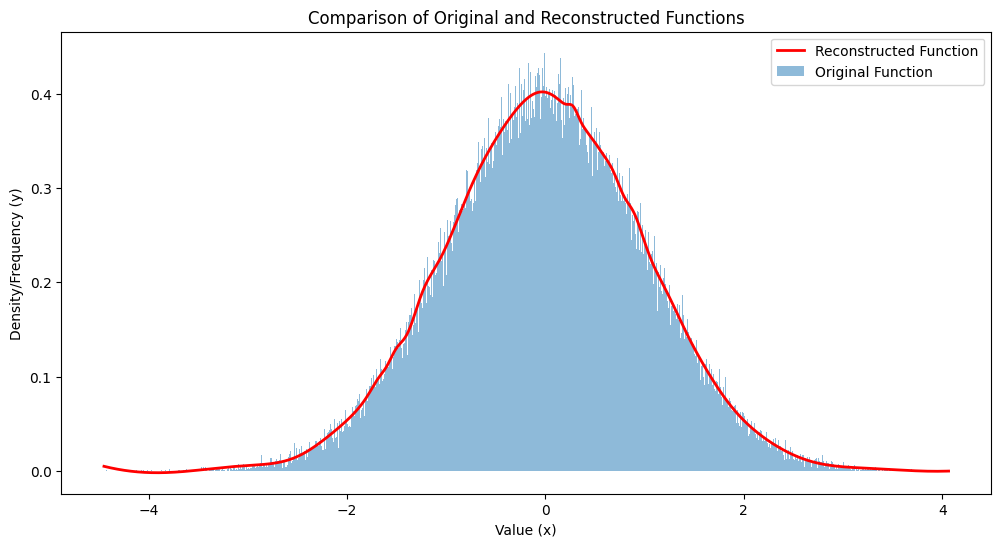

In [58]:
rbf_layer= RBFLayerModified(
    in_features_dim=1,
    num_kernels=100,
    out_features_dim=1,
    radial_function=gaussian_rbf,
    norm_function=l2_norm
)
rbf_layer.weights = nn.Parameter(learned_weights)
rbf_layer.kernels_centers = nn.Parameter(learned_centers)
rbf_layer.log_shapes = nn.Parameter(learned_shapes)
y_pred_train = rbf_layer(x_train).detach()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x_train.squeeze(), y_pred_train.squeeze(), label='Reconstructed Function', color='red', linewidth=2)
plt.bar(x_train.squeeze(), y_train.squeeze(), width=(bin_edges[1]-bin_edges[0]), alpha=0.5, label='Original Function')
plt.title('Comparison of Original and Reconstructed Functions')
plt.xlabel('Value (x)')
plt.ylabel('Density/Frequency (y)')
plt.legend()
plt.show()